In [1]:
#file name: tourism.ipynb
#author: Solange  
#Objective: To predict which customer is more likely to purchase the newly introduced travel package.
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
#from xgboost import XGBRegressor #<-this requires library install

In [2]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [3]:
# Two sample t-test for comparing mean

import scipy.stats as st
#Lets define some useful stats quantities for analysis
def ssdev(X):
    xbar = np.mean(X)
    s= sum([(x-xbar)**2 for x in X])
    ssd =( s / (len(X)-1) )**.5
    return ssd
def tstat(xb1, xb2, ss1, ss2, n1, n2):
    #this is a rough estimator and not using pooled t-test
    print("tstat: xb1, xb2, ss1, ss2, n1, n2 ")
    print(str([xb1, xb2, ss1, ss2, n1, n2]) )
    SE = (ss1**2/n1 + ss2**2/n2)**.5
    ts = (xb1 - xb2)/SE
    return ts
def twos_twotail_ttest(Samp1, Samp2, sig):
    x_bar_1 = np.mean(Samp1)
    x_bar_2 = np.mean(Samp2)
    ssdev_1 = ssdev(Samp1)
    ssdev_2 = ssdev(Samp2)
#the degrees of freedom is the smaller of the two n1-1 and n2-1
    df_12 = min(len(Samp1), len(Samp2)) -1
    #print the critical values designating the ending and beginning of rejection region
    print(st.t.interval(alpha=(1-sig), df=df_12, loc=0, scale=1) )
#lastly, calculate the t-stsat
    t_s = tstat(x_bar_1, x_bar_2, ssdev_1, ssdev_2, len(Samp1), len(Samp2))
    print(t_s)

In [4]:
def zstat(x1, x2, n1, n2):
    p1 = x1/n1
    p2 = x2/n2
    pooled_prop = (p1*n1+p2*n2)/(n1+n2)
    SE = (pooled_prop*(1-pooled_prop)*(1/n1+1/n2))**.5
    z_stat = (p1-p2)/SE
    return z_stat
def twoprop_twotail_z(Samp1, Samp2, sig):
    #note Samp1 and Samp2 are assumed to have binary value 0 or 1
    print(st.norm.interval(alpha=(1-sig), loc=0, scale=1) )
    z_s = zstat(sum(Samp1), sum(Samp2), len(Samp1), len(Samp2))
    print(z_s)

In [5]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_val)
    
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_val,y_val)
    
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_val,pred_test)
    
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_val,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_val,y_val))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_val,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_val,pred_test))
    
    return score_list # returning the list with train and test scores

In [6]:
#Specify and open/read the raw data file to DataFrame
tourism_data_file_reference = "tourism.csv"
tourism_data = pd.read_csv(tourism_data_file_reference)

In [7]:
#Checking that the import was successful and previewing which data need to be cleaned
tourism_data.describe()

,CustomerID,ProdTaken,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,MonthlyIncome
count,4888.000000,4888.000000,4662.000000,4888.000000,4637.000000,4888.000000,4843.000000,4862.000000,4748.000000,4888.000000,4888.000000,4888.000000,4822.000000,4655.000000
mean,202443.500000,0.188216,37.622265,1.654255,15.490835,2.905074,3.708445,3.581037,3.236521,0.290917,3.078151,0.620295,1.187267,23619.853491
std,1411.188388,0.390925,9.316387,0.916583,8.519643,0.724891,1.002509,0.798009,1.849019,0.454232,1.365792,0.485363,0.857861,5380.698361
min,200000.000000,0.000000,18.000000,1.000000,5.000000,1.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1000.000000
25%,201221.750000,0.000000,31.000000,1.000000,9.000000,2.000000,3.000000,3.000000,2.000000,0.000000,2.000000,0.000000,1.000000,20346.000000
50%,202443.500000,0.000000,36.000000,1.000000,13.000000,3.000000,4.000000,3.000000,3.000000,0.000000,3.000000,1.000000,1.000000,22347.000000
75%,203665.250000,0.000000,44.000000,3.000000,20.000000,3.000000,4.000000,4.000000,4.000000,1.000000,4.000000,1.000000,2.000000,25571.000000
max,204887.000000,1.000000,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,5.000000,1.000000,3.000000,98678.000000


In [8]:
tourism_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                4888 non-null   int64  
 1   ProdTaken                 4888 non-null   int64  
 2   Age                       4662 non-null   float64
 3   TypeofContact             4863 non-null   object 
 4   CityTier                  4888 non-null   int64  
 5   DurationOfPitch           4637 non-null   float64
 6   Occupation                4888 non-null   object 
 7   Gender                    4888 non-null   object 
 8   NumberOfPersonVisiting    4888 non-null   int64  
 9   NumberOfFollowups         4843 non-null   float64
 10  ProductPitched            4888 non-null   object 
 11  PreferredPropertyStar     4862 non-null   float64
 12  MaritalStatus             4888 non-null   object 
 13  NumberOfTrips             4748 non-null   float64
 14  Passport

In [9]:
tourism_data.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [10]:
#The ProdTaken column is the one we are trying to predict using the binary classifier models 
# Age, DurationOfPitch, NumberOfFollowups, PreferredPropertyStar, NumberOfTrips, 
# NumberOfChildrenVisiting, MonthlyIncome
#Dropping two columns from the dataframe

#Firstly, customer id is an unhelpful index (not helpful for prediction)
tourism_data.drop(columns=['CustomerID'], inplace=True)

In [11]:
#Pull all columns excetp the response 
tourism_cols = tourism_data.columns.tolist()
tourism_cols.remove('ProdTaken')
print(tourism_cols)

['Age', 'TypeofContact', 'CityTier', 'DurationOfPitch', 'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'ProductPitched', 'PreferredPropertyStar', 'MaritalStatus', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar', 'NumberOfChildrenVisiting', 'Designation', 'MonthlyIncome']


In [12]:
#remove the ones that are nan
copy_tourism_data = tourism_data.dropna()

In [13]:
#Divide using train test split
y = copy_tourism_data["ProdTaken"]
X = copy_tourism_data[tourism_cols]#independent variables
X_train, X_val, y_train, y_val= train_test_split(X, y, random_state = 0)

In [14]:
# Get list of categorical variables
#https://www.kaggle.com/alexisbcook/categorical-variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'MaritalStatus', 'Designation']


In [15]:
#Next Use One-Hot encoder to turn categorical columns into encoded values

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_val[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_val.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_val.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

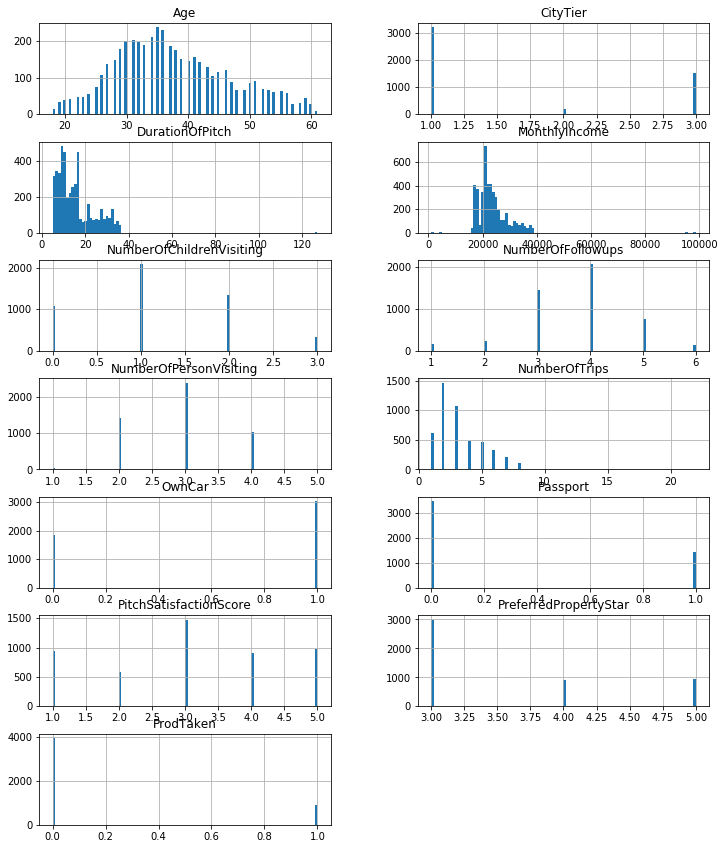

In [16]:
#Visualize the distributions of all data
tourism_data.hist(stacked=False, bins=100, figsize=(12,30), layout=(14,2));

In [17]:
#Looking For Correlations to See what might be useful to test
# However we want to see correlation in graphical representation so below is function for that
import numpy as np
def plot_corr(df, size=11):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns)
    plt.yticks(range(len(corr.columns)), corr.columns)
    for (i, j), z in np.ndenumerate(corr):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

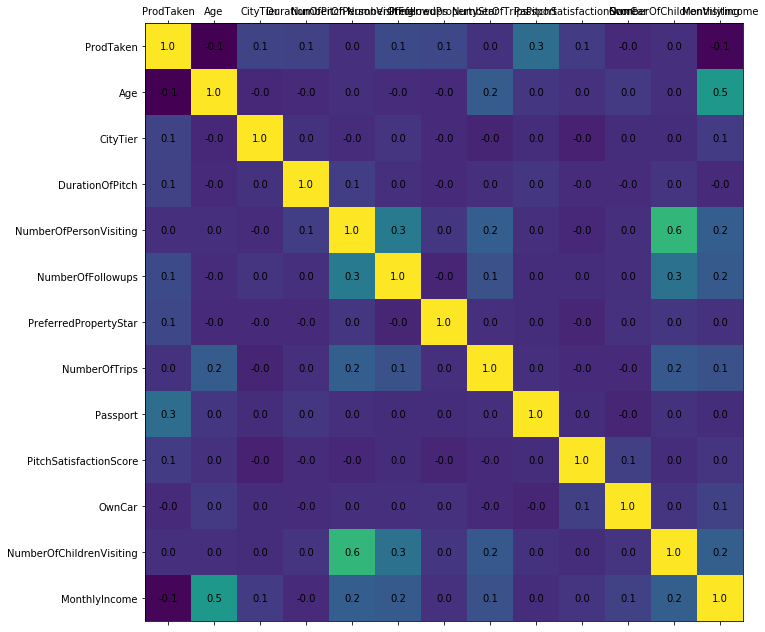

In [18]:
plot_corr(tourism_data)

In [19]:
#Scrub Duration of Pitch, Number of Trips, MonthlyIncome of Outliers
#Outlier Cutoffs
#It is more useful to visualize and generate regresion from KM_Driven that does not contain outliers
quantitative=['DurationOfPitch','NumberOfTrips','MonthlyIncome']
seventy_fifth=[20.000000, 	4.000000, 25571.000000]
twenty_fifth=[9.000000, 2.000000, 20346.000000]
cutoffs, upperco, lowerco =[],[],[]
for i in range(len(seventy_fifth)): cutoffs.append( (seventy_fifth[i] - twenty_fifth[i])*1.5 ) 
for i in range(len(seventy_fifth)): upperco.append( seventy_fifth[i] + cutoffs[i] ) 
for i in range(len(seventy_fifth)): lowerco.append( twenty_fifth[i] - cutoffs[i] ) 

print("Outliers fall below:")

print(lowerco)
print("Outliers extend above:")
print(upperco)

print(quantitative)
#you will see that though it doesn't make sense to cal outlier by S.No 
#outliers exist for Year, Kilometers Driven, Seats and Price 

Outliers fall below:
[-7.5, -1.0, 12508.5]
Outliers extend above:
[36.5, 7.0, 33408.5]
['DurationOfPitch', 'NumberOfTrips', 'MonthlyIncome']


In [20]:
#Using Appended concatinated set for the analyses
y_train.append(y_val)
OH_X_train.append(OH_X_valid)#'OH_' if one hot categoricals
clean_tourism_data = pd.concat([y_train,OH_X_train], axis=1)#same as above

In [21]:
wout_MI_outliers, MI_outlieres =  [x for _, x in clean_tourism_data.groupby(tourism_data['MonthlyIncome'] < 12508.5)]
wout_MI_outliers, MI_outlieres =  [x for _, x in wout_MI_outliers.groupby(wout_MI_outliers['MonthlyIncome'] > 33408.5)]
wout_NT_outliers, NT_outlieres =  [x for _, x in wout_MI_outliers.groupby(wout_MI_outliers['NumberOfTrips'] > 7 )]
wout_DoP_outliers, DoP_outlieres =  [x for _, x in wout_NT_outliers.groupby(wout_NT_outliers['DurationOfPitch'] > 36.5 )]

In [22]:
#__________DATA CLEANED, SPLIT BY RESPONSE
df_prodtaken_y, df_prodtaken_n = [x for _, x in wout_DoP_outliers.groupby(wout_DoP_outliers['ProdTaken'] == 0)]

In [23]:
df_prodtaken_y.describe()

,ProdTaken,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,...,13,14,15,16,17,18,19,20,21,22
count,557.0,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,...,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000,557.000000
mean,1.0,34.147217,1.834829,17.418312,2.933573,3.938959,3.761221,3.154399,0.549372,3.238779,...,0.017953,0.131059,0.350090,0.310592,0.208259,0.017953,0.606822,0.215440,0.157989,0.001795
std,0.0,9.912379,0.960370,8.568968,0.705250,0.976269,0.860026,1.704164,0.498004,1.340596,...,0.132901,0.337768,0.477427,0.463152,0.406428,0.132901,0.488895,0.411497,0.365059,0.042371
min,1.0,18.000000,1.000000,6.000000,2.000000,1.000000,3.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,27.000000,1.000000,10.000000,2.000000,3.000000,3.000000,2.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,32.000000,1.000000,15.000000,3.000000,4.000000,3.000000,3.000000,1.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.0,40.000000,3.000000,24.000000,3.000000,5.000000,5.000000,4.000000,1.000000,4.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.0,59.000000,3.000000,36.000000,4.000000,6.000000,5.000000,7.000000,1.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
df_prodtaken_n.describe()

,ProdTaken,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,...,13,14,15,16,17,18,19,20,21,22
count,2370.0,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,...,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000,2370.000000
mean,0.0,37.600000,1.629114,15.335865,2.954430,3.691561,3.530802,3.173418,0.236709,3.007595,...,0.066245,0.206329,0.504641,0.129958,0.159072,0.066245,0.341350,0.397046,0.191139,0.004219
std,0.0,8.714621,0.911210,8.231370,0.726127,0.987796,0.768263,1.590618,0.425152,1.352243,...,0.248762,0.404755,0.500084,0.336328,0.365820,0.248762,0.474263,0.489389,0.393281,0.064833
min,0.0,18.000000,1.000000,5.000000,1.000000,1.000000,3.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,31.000000,1.000000,9.000000,2.000000,3.000000,3.000000,2.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,36.000000,1.000000,13.000000,3.000000,4.000000,3.000000,3.000000,0.000000,3.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,43.000000,3.000000,19.000000,3.000000,4.000000,4.000000,4.000000,0.000000,4.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,0.0,61.000000,3.000000,36.000000,5.000000,6.000000,5.000000,7.000000,1.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


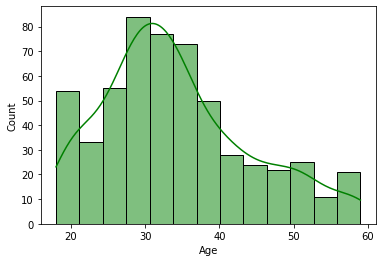

In [25]:
#Age
sns.histplot(df_prodtaken_y['Age'], kde=True, color='green')

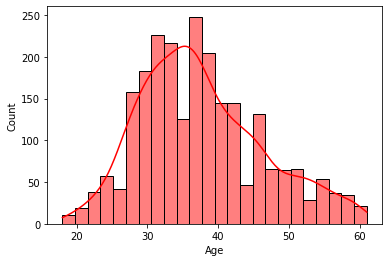

In [26]:
sns.histplot(df_prodtaken_n['Age'], kde=True, color='red')

In [27]:
#Ages can be assumed to be roughly normal and independent of one another
#H0 : mean age is the same between package status
#H1 : mean age is different between package status
# significance = .05
twos_twotail_ttest(df_prodtaken_n['Age'], df_prodtaken_y['Age'], .05)

(-1.9642398045825449, 1.9642398045825449)
tstat: xb1, xb2, ss1, ss2, n1, n2 
[37.6, 34.147217235188506, 8.714620931645323, 9.912379458175925, 2370, 557]
7.562641869092792


In [28]:
#7.9 for the t statistic is outside the range therefore the means are statistically different

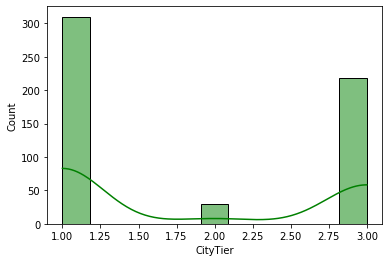

In [29]:
#CityTeir
sns.histplot(df_prodtaken_y['CityTier'], kde=True, color='green')

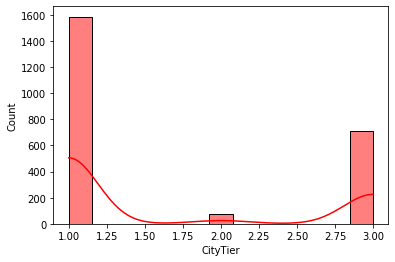

In [30]:
sns.histplot(df_prodtaken_n['CityTier'], kde=True, color='red')

In [31]:
#The two prop z can be used on City teir, npq>10 and binomial situation is '=1' success, 
# with '!=1' fail
#H0 : prop city teir is the same between package status 
#H1 : prop city teir different between package status
# significance = .05
nCT_is1, nCT_isnt1 = [x for _, x in df_prodtaken_n.groupby(df_prodtaken_n['CityTier'] != 1)]
nencodeCT = [1]*len(nCT_is1['CityTier'])
nencodeCT.extend([0]*len(nCT_isnt1))
yCT_is1, yCT_isnt1 = [x for _, x in df_prodtaken_y.groupby(df_prodtaken_y['CityTier'] != 1)]
yencodeCT = [1]*len(yCT_is1['CityTier'])
yencodeCT.extend([0]*len(yCT_isnt1))
twoprop_twotail_z(nencodeCT, yencodeCT, .05)#(df_prodtaken_n['CityTier'], df_prodtaken_y['CityTier'], sig)

(-1.959963984540054, 1.959963984540054)
5.008156609423943


In [32]:
#therefore, city tier is statistically different

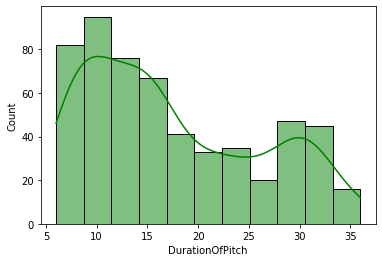

In [33]:
#DurationOfPitch
sns.histplot(df_prodtaken_y['DurationOfPitch'], kde=True, color='green')

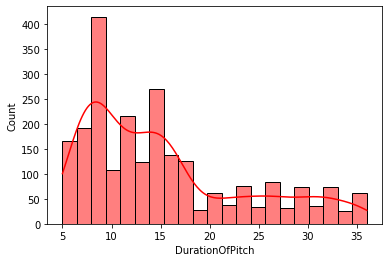

In [34]:
sns.histplot(df_prodtaken_n['DurationOfPitch'], kde=True, color='red')

In [35]:
#DurationOfPitch
#The two prop z can be used on DurationOfPitch, npq>10 and binomial situation is '<20' success, 
# with '>=20' fail
#H0 : prop DurationOfPitch is the same between package status 
#H1 : prop DurationOfPitch different between package status
# significance = .05
DoP = 'DurationOfPitch'
nDoP_isunder20, nDoP_isntunder20 = [x for _, x in df_prodtaken_n.groupby(df_prodtaken_n[DoP] >= 20)]
nencode_DoP = [1]*len(nDoP_isunder20[DoP])
nencode_DoP.extend([0]*len(nDoP_isntunder20))
yDoP_isunder20, yDoP_isntunder20 = [x for _, x in df_prodtaken_y.groupby(df_prodtaken_y[DoP] >= 20)]
yencode_DoP = [1]*len(yDoP_isunder20[DoP])
yencode_DoP.extend([0]*len(yDoP_isntunder20))
twoprop_twotail_z(nencode_DoP, yencode_DoP, .05)

(-1.959963984540054, 1.959963984540054)
4.888252740790541


In [36]:
#therefore, Duration of Pitch is statistically different

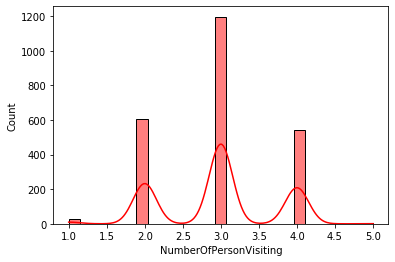

In [37]:
#NumberOfPersonVisiting
sns.histplot(df_prodtaken_n['NumberOfPersonVisiting'], kde=True, color='red')

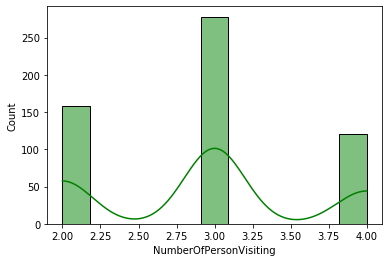

In [38]:
sns.histplot(df_prodtaken_y['NumberOfPersonVisiting'], kde=True, color='green')

In [39]:
#Number of Person Visiting can be assumed to be roughly normal and independent of one another
#H0 : mean Numberof Persons Visiting is the same between package status
#H1 : mean Numberof Persons Visiting is different between package status
# significance = .05
twos_twotail_ttest(df_prodtaken_n['NumberOfPersonVisiting'], df_prodtaken_y['NumberOfPersonVisiting'], .05)

(-1.9642398045825449, 1.9642398045825449)
tstat: xb1, xb2, ss1, ss2, n1, n2 
[2.9544303797468356, 2.933572710951526, 0.726126577294003, 0.7052503386154999, 2370, 557]
0.6245171353472931


In [40]:
#Number of Person Visiting is therefore not statistically impactful
df_prodtaken_n.drop(columns=['NumberOfPersonVisiting'], inplace=True)
df_prodtaken_y.drop(columns=['NumberOfPersonVisiting'], inplace=True)

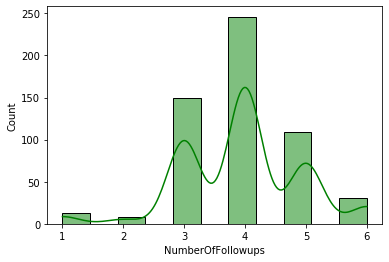

In [41]:
#NumberOfFollowups
sns.histplot(df_prodtaken_y['NumberOfFollowups'], kde=True, color='green')

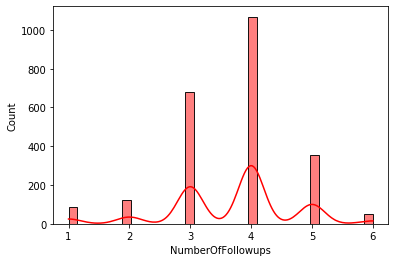

In [42]:
sns.histplot(df_prodtaken_n['NumberOfFollowups'], kde=True, color='red')

In [43]:
#number of followups can be assumed to be roughly normal and independent of one another
#H0 : mean number of followups is the same between package status
#H1 : mean number of followups is different between package status
# significance = .05
twos_twotail_ttest(df_prodtaken_n['NumberOfFollowups'], df_prodtaken_y['NumberOfFollowups'], .05)

(-1.9642398045825449, 1.9642398045825449)
tstat: xb1, xb2, ss1, ss2, n1, n2 
[3.691561181434599, 3.938958707360862, 0.987796201363374, 0.9762693232184035, 2370, 557]
-5.369536194779739


In [44]:
#number of followups is statistically different 

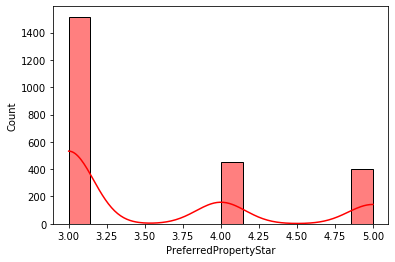

In [45]:
#PreferredPropertyStar
sns.histplot(df_prodtaken_n['PreferredPropertyStar'], kde=True, color='red')

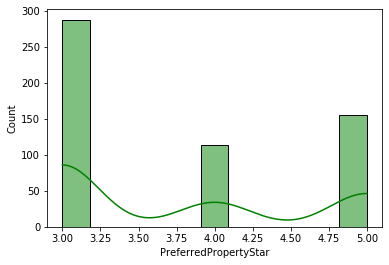

In [46]:
sns.histplot(df_prodtaken_y['PreferredPropertyStar'], kde=True, color='green')

In [47]:
#PreferredPropertyStar
#The two prop z can be used on DurationOfPitch, npq>10 and binomial situation is '=3' success, 
# with '>=4' fail
#H0 : prop DurationOfPitch is the same between package status 
#H1 : prop DurationOfPitch different between package status
# significance = .05
PPS = 'PreferredPropertyStar'
nPPS_isunder4, nPPS_isntunder4 = [x for _, x in df_prodtaken_n.groupby(df_prodtaken_n[PPS] != 3)]
nencode_PPS = [1]*len(nPPS_isunder4[PPS])
nencode_PPS.extend([0]*len(nPPS_isntunder4))
yPPS_isunder4, yPPS_isntunder4 = [x for _, x in df_prodtaken_y.groupby(df_prodtaken_y[PPS] != 3)]
yencode_PPS = [1]*len(yPPS_isunder4[PPS])
yencode_PPS.extend([0]*len(yPPS_isntunder4))
twoprop_twotail_z(nencode_PPS, yencode_PPS, .05)

(-1.959963984540054, 1.959963984540054)
5.354507315201065


In [48]:
#Reject null, the Prefered Property Star Is different between groups

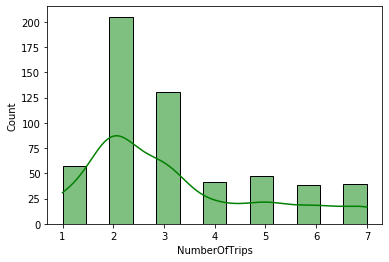

In [49]:
#NumberOfTrips
sns.histplot(df_prodtaken_y['NumberOfTrips'], kde=True, color='green')

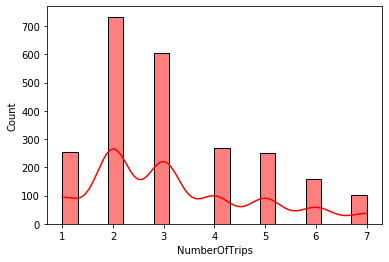

In [50]:
sns.histplot(df_prodtaken_n['NumberOfTrips'], kde=True, color='red')

In [51]:
#NumberOfTrips
#The two prop z can be used on NumberOfTrips, npq>10 and binomial situation is '<5' success, 
# with '>=5' fail
#H0 : prop NumberOfTrips is the same between package status 
#H1 : prop NumberOfTrips different between package status
# significance = .05
NOT = 'NumberOfTrips'
nNOT_isunder5, nNOT_isntunder5 = [x for _, x in df_prodtaken_n.groupby(df_prodtaken_n[NOT] >= 5)]
nencode_NOT = [1]*len(nNOT_isunder5[NOT])
nencode_NOT.extend([0]*len(nNOT_isntunder5))
yNOT_isunder5, yNOT_isntunder5 = [x for _, x in df_prodtaken_y.groupby(df_prodtaken_y[NOT] >= 5)]
yencode_NOT = [1]*len(yNOT_isunder5[NOT])
yencode_NOT.extend([0]*len(yNOT_isntunder5))
twoprop_twotail_z(nencode_NOT, yencode_NOT, .05)

(-1.959963984540054, 1.959963984540054)
0.38311745730893587


In [52]:
#Number of trip is not statistically significant
df_prodtaken_n.drop(columns=[NOT], inplace=True)
df_prodtaken_y.drop(columns=[NOT], inplace=True)

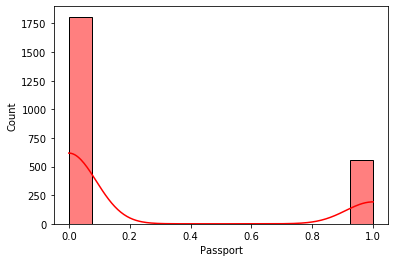

In [53]:
#Passport
sns.histplot(df_prodtaken_n['Passport'], kde=True, color='red')

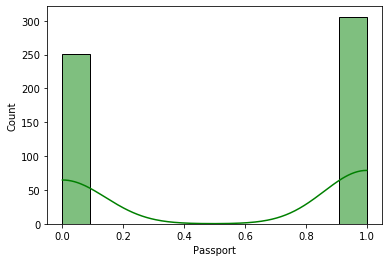

In [54]:
sns.histplot(df_prodtaken_y['Passport'], kde=True, color='green')

In [55]:
#Passport
#The two prop z can be used on PPassport, npq>10 and binomial situation is '=1' success, 
# with '!=0' fail
#H0 : prop Passport is the same between package status 
#H1 : prop Passport different between package status
# significance = .05
psp = 'Passport'
npsp_is1, npsp_isnt1 = [x for _, x in df_prodtaken_n.groupby(df_prodtaken_n[psp] != 1)]
nencode_psp = [1]*len(npsp_is1[PPS])
nencode_psp.extend([0]*len(npsp_isnt1))
ypsp_is1, ypsp_isnt1 = [x for _, x in df_prodtaken_y.groupby(df_prodtaken_y[psp] != 1)]
yencode_psp = [1]*len(ypsp_is1[PPS])
yencode_psp.extend([0]*len(ypsp_isnt1))
twoprop_twotail_z(nencode_psp, yencode_psp, .05)

(-1.959963984540054, 1.959963984540054)
-14.542736934926072


In [56]:
#Passport is a factor

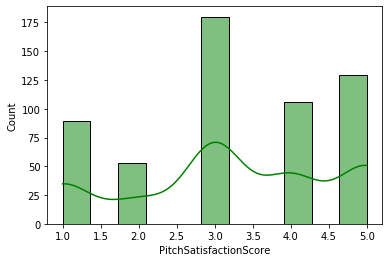

In [57]:
#PitchSatisfactionScore
sns.histplot(df_prodtaken_y['PitchSatisfactionScore'], kde=True, color='green')

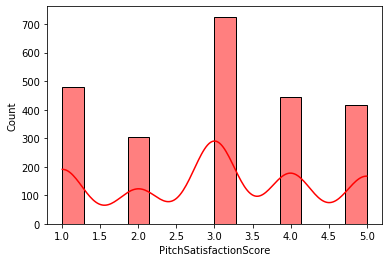

In [58]:
sns.histplot(df_prodtaken_n['PitchSatisfactionScore'], kde=True, color='red')

In [59]:
#PitchSatisfactionScore can be assumed to be roughly normal and independent of one another
#H0 : mean PitchSatisfactionScore is the same between package status
#H1 : mean PitchSatisfactionScore is different between package status
# significance = .05
twos_twotail_ttest(df_prodtaken_n['PitchSatisfactionScore'], df_prodtaken_y['PitchSatisfactionScore'], .05)

(-1.9642398045825449, 1.9642398045825449)
tstat: xb1, xb2, ss1, ss2, n1, n2 
[3.007594936708861, 3.238779174147217, 1.3522433077425087, 1.3405963251119408, 2370, 557]
-3.6562060886467576


In [60]:
#this is statistically significant so PitchSatisfaction Score is a factor

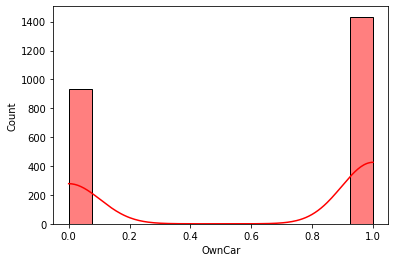

In [61]:
#OwnCar
sns.histplot(df_prodtaken_n['OwnCar'], kde=True, color='red')

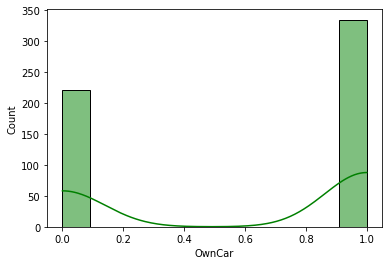

In [62]:
sns.histplot(df_prodtaken_y['OwnCar'], kde=True, color='green')

In [63]:
#OwnCar
#The two prop z can be used on OwnCar, npq>10 and binomial situation is '=1' success, 
# with '!=0' fail
#H0 : prop OwnCar is the same between package status 
#H1 : prop OwnCar different between package status
# significance = .05
OC = 'OwnCar'
nOC_is1, nOC_isnt1 = [x for _, x in df_prodtaken_n.groupby(df_prodtaken_n[OC] != 1)]
nencode_OC = [1]*len(nOC_is1[OC])
nencode_OC.extend([0]*len(nOC_isnt1))
yOC_is1, yOC_isnt1 = [x for _, x in df_prodtaken_y.groupby(df_prodtaken_y[OC] != 1)]
yencode_OC = [1]*len(yOC_is1[OC])
yencode_OC.extend([0]*len(yOC_isnt1))
twoprop_twotail_z(nencode_OC, yencode_OC, .05)

(-1.959963984540054, 1.959963984540054)
0.15752356652953106


In [64]:
#Car Ownership is not a factor
df_prodtaken_n.drop(columns=[OC], inplace=True)
df_prodtaken_y.drop(columns=[OC], inplace=True)

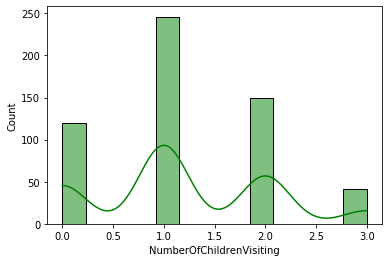

In [65]:
#NumberOfChildrenVisiting
sns.histplot(df_prodtaken_y['NumberOfChildrenVisiting'], kde=True, color='green')

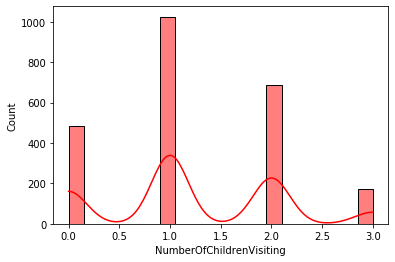

In [66]:
sns.histplot(df_prodtaken_n['NumberOfChildrenVisiting'], kde=True, color='r')

In [67]:
#NumberOfChildrenVisiting can be assumed to be roughly normal and independent of one another
#H0 : mean NumberOfChildrenVisiting is the same between package status
#H1 : mean NumberOfChildrenVisiting is different between package status
# significance = .05
nocv = 'NumberOfChildrenVisiting'
twos_twotail_ttest(df_prodtaken_n[nocv], df_prodtaken_y[nocv], .05)

(-1.9642398045825449, 1.9642398045825449)
tstat: xb1, xb2, ss1, ss2, n1, n2 
[1.230379746835443, 1.2010771992818672, 0.8565819601069663, 0.860273665760364, 2370, 557]
0.7239579535507047


In [68]:
#numbrer of children visiting is not a factor
df_prodtaken_n.drop(columns=[nocv], inplace=True)
df_prodtaken_y.drop(columns=[nocv], inplace=True)

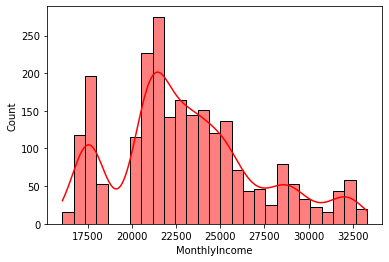

In [69]:
#MonthlyIncome
sns.histplot(df_prodtaken_n['MonthlyIncome'], kde=True, color='r')

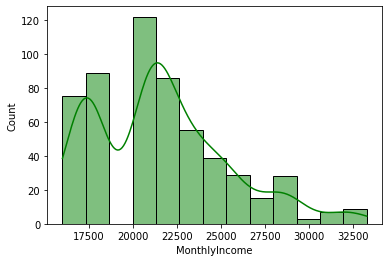

In [70]:
sns.histplot(df_prodtaken_y['MonthlyIncome'], kde=True, color='g')

In [71]:
#MonthlyIncome
#The two prop z can be used on MonthlyIncome, npq>10 and binomial situation is '<26000' success, 
# with '!=0' fail
#H0 : prop MonthlyIncome is the same between package status 
#H1 : prop MonthlyIncome different between package status
# significance = .05
MI = 'MonthlyIncome'
nMI_is1, nMI_isnt1 = [x for _, x in df_prodtaken_n.groupby(df_prodtaken_n[MI] >= 26000)]
nencode_MI = [1]*len(nMI_is1[MI])
nencode_MI.extend([0]*len(nMI_isnt1))
yMI_is1, yMI_isnt1 = [x for _, x in df_prodtaken_y.groupby(df_prodtaken_y[MI] >= 26000)]
yencode_MI = [1]*len(yMI_is1[MI])
yencode_MI.extend([0]*len(yMI_isnt1))
twoprop_twotail_z(nencode_MI, yencode_MI, .05)

(-1.959963984540054, 1.959963984540054)
-4.119906424162812


In [72]:
#MonthlyIncome is a factor

In [73]:
#CATEGORICAL ANALYSIS
cat_tourism_data = tourism_data.dropna()
cat_prodtaken_y, cat_prodtaken_n = [x for _, x in cat_tourism_data.groupby(cat_tourism_data['ProdTaken'] == 0)]

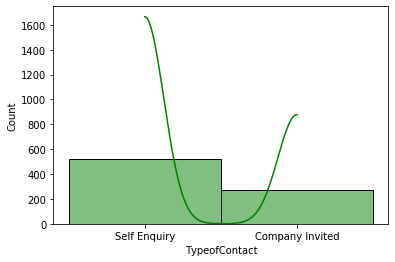

In [74]:
#TypeofContact
sns.histplot(cat_prodtaken_y['TypeofContact'], kde=True, color='g')

In [75]:
typeofContact_CI, typeofContact = [x for _, x in cat_prodtaken_y.groupby(cat_prodtaken_y['TypeofContact'] != "Company Invited")]

In [76]:
companyinvited = len(typeofContact_CI)
total = companyinvited+len(typeofContact)
print(companyinvited)
print(total)

275
797


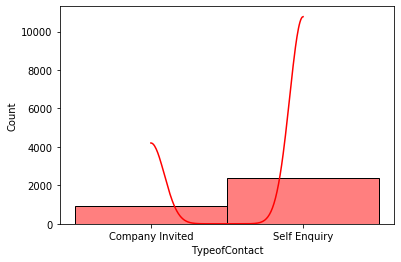

In [77]:
sns.histplot(cat_prodtaken_n['TypeofContact'], kde=True, color='r')

In [78]:
#We can tell from plots alone that TypeofContact Matters

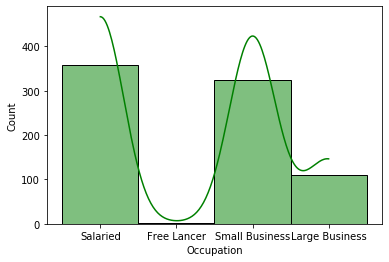

In [79]:
#Occupation
sns.histplot(cat_prodtaken_y['Occupation'], kde=True, color='g')

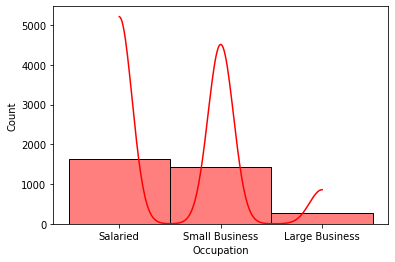

In [80]:
sns.histplot(cat_prodtaken_n['Occupation'], kde=True, color='r')

In [81]:
#The two prop z can be used on Occupation, npq>10 and binomial situation is 'Salaried' success, 
# with '!=Salaried' fail
#H0 : prop Salaried is the same between package status 
#H1 : prop Salaried different between package status
# significance = .05
O = 'Occupation'
nSAL_is1, nSAL_isnt1 = [x for _, x in cat_prodtaken_n.groupby(cat_prodtaken_n[O] != 'Salaried')]
nencode_SAL = [1]*len(nSAL_is1[O])
nencode_SAL.extend([0]*len(nSAL_isnt1))
ySAL_is1, ySAL_isnt1 = [x for _, x in cat_prodtaken_y.groupby(cat_prodtaken_y[O] != 'Salaried')]
yencode_SAL = [1]*len(ySAL_is1[O])
yencode_SAL.extend([0]*len(ySAL_isnt1))
twoprop_twotail_z(nencode_SAL, yencode_SAL, .05)

(-1.959963984540054, 1.959963984540054)
2.126488619921936


In [82]:
#Occupation Matters

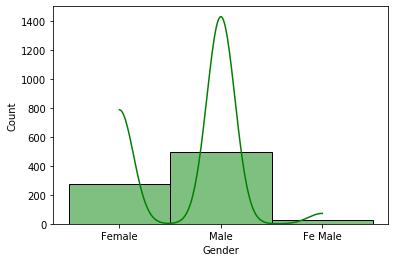

In [83]:
#Gender
sns.histplot(cat_prodtaken_y['Gender'], kde=True, color='g')

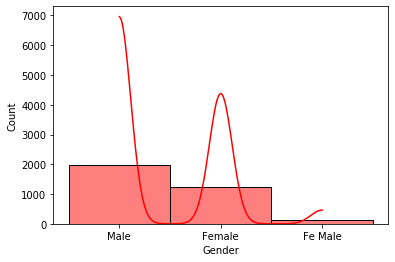

In [84]:
sns.histplot(cat_prodtaken_n['Gender'], kde=True, color='r')

In [85]:
#based on the histograms, gender is a factor

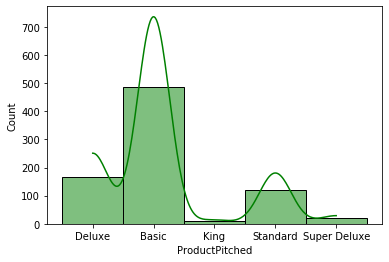

In [86]:
#ProductPitched
sns.histplot(cat_prodtaken_y['ProductPitched'], kde=True, color='g')

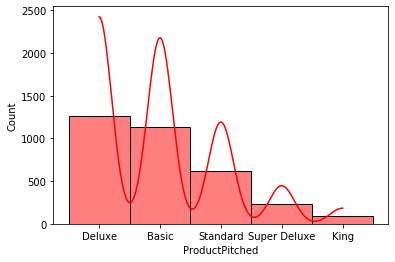

In [87]:
sns.histplot(cat_prodtaken_n['ProductPitched'], kde=True, color='r')

In [88]:
#based on the histograms, Product Pitched is also a factor

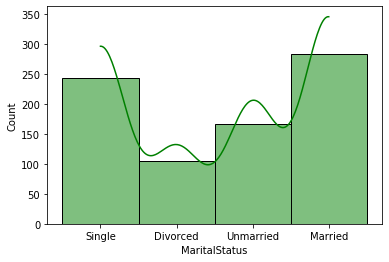

In [89]:
#MaritalStatus
sns.histplot(cat_prodtaken_y['MaritalStatus'], kde=True, color='g')

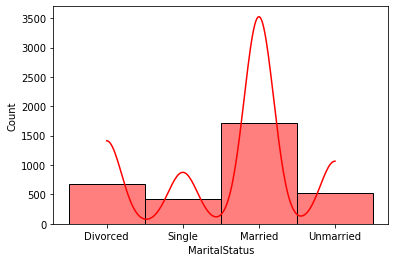

In [90]:
sns.histplot(cat_prodtaken_n['MaritalStatus'], kde=True, color='r')

In [91]:
#based on the histograms, marital status is also a factor

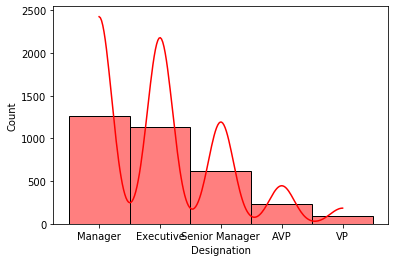

In [92]:
#Designation
sns.histplot(cat_prodtaken_n['Designation'], kde=True, color='r')

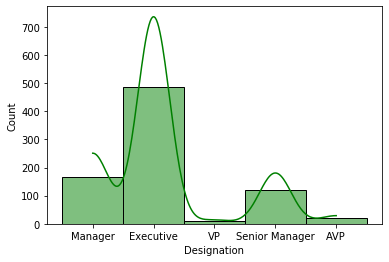

In [93]:
sns.histplot(cat_prodtaken_y['Designation'], kde=True, color='g')

In [94]:
#based on the histograms, designation is also a factor

In [95]:
#Hypothesis with Bivariate correlation

In [96]:
#____________________MODEL BUILDING
all_cols = tourism_data.columns.tolist()
nan_imputed = pd.DataFrame(columns=all_cols)
print(nan_imputed.columns.tolist())

['ProdTaken', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch', 'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'ProductPitched', 'PreferredPropertyStar', 'MaritalStatus', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar', 'NumberOfChildrenVisiting', 'Designation', 'MonthlyIncome']


In [97]:
def merge(l1, l2):
    for item in l1:
        if item not in l2:
            l2.append(item)
    return l2
merge([1,3,5,7],[2,3,4,6,8,10])

[2, 3, 4, 6, 8, 10, 1, 5, 7]

In [98]:
import math
#math.isnan(tourism_data['Age'][4])
ir=[]#null row index
for col in all_cols:
    ir = merge(tourism_data[tourism_data[col].isnull()].index.tolist(),ir)
print(len(ir))

760


In [99]:
nan_imputed = nan_imputed.append(tourism_data.iloc[ir])

In [100]:
nan_imputed.info() #Not yet imputed

<class 'pandas.core.frame.DataFrame'>
Int64Index: 760 entries, 4 to 2209
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ProdTaken                 760 non-null    object 
 1   Age                       534 non-null    float64
 2   TypeofContact             735 non-null    object 
 3   CityTier                  760 non-null    object 
 4   DurationOfPitch           509 non-null    float64
 5   Occupation                760 non-null    object 
 6   Gender                    760 non-null    object 
 7   NumberOfPersonVisiting    760 non-null    object 
 8   NumberOfFollowups         715 non-null    float64
 9   ProductPitched            760 non-null    object 
 10  PreferredPropertyStar     734 non-null    float64
 11  MaritalStatus             760 non-null    object 
 12  NumberOfTrips             620 non-null    float64
 13  Passport                  760 non-null    object 
 14  PitchSati

In [101]:
#add to the without outliers
#wout_MI_os_nan, MI_os_nan =  [x for _, x in nan_imputed.groupby(nan_imputed['MonthlyIncome'] < 12508.5)]
#wout_MI_os_nan, MI_os_nan =  [x for _, x in wout_MI_os_nan.groupby(wout_MI_os_nan['MonthlyIncome'] > 33408.5)]
#wout_NT_os_nan, NT_os_nan =  [x for _, x in wout_MI_outliers.groupby(wout_MI_os_nan['NumberOfTrips'] > 7 )]
#wout_DoP_os_nan, DoP_os_nan =  [x for _, x in wout_NT_outliers.groupby(wout_NT_os_nan['DurationOfPitch'] > 36.5 )]

In [102]:
object_cols

['TypeofContact',
 'Occupation',
 'Gender',
 'ProductPitched',
 'MaritalStatus',
 'Designation']

In [103]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [104]:
wout_DoP_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 2990 to 3345
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ProdTaken                 2927 non-null   int64  
 1   Age                       2927 non-null   float64
 2   CityTier                  2927 non-null   int64  
 3   DurationOfPitch           2927 non-null   float64
 4   NumberOfPersonVisiting    2927 non-null   int64  
 5   NumberOfFollowups         2927 non-null   float64
 6   PreferredPropertyStar     2927 non-null   float64
 7   NumberOfTrips             2927 non-null   float64
 8   Passport                  2927 non-null   int64  
 9   PitchSatisfactionScore    2927 non-null   int64  
 10  OwnCar                    2927 non-null   int64  
 11  NumberOfChildrenVisiting  2927 non-null   float64
 12  MonthlyIncome             2927 non-null   float64
 13  0                         2927 non-null   float64
 14  1    

In [125]:
stick_this_on_wout_DoP_outliers = nan_imputed.drop(object_cols, axis=1)

In [154]:
len(X_train)

3096

In [156]:
#testdf = pd.DataFrame({'my iq':[100,120,140]})
X_train.index = list(set(range(4889,4889+len(X_train))))
X_train.head()

,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
4889,38.0,Self Enquiry,1,9.0,Free Lancer,Male,4,5.0,Basic,3.0,Single,8.0,1,3,0,1.0,Executive,20768.0
4890,30.0,Self Enquiry,3,17.0,Salaried,Male,3,4.0,Basic,3.0,Unmarried,3.0,0,4,0,1.0,Executive,21320.0
4891,31.0,Company Invited,1,16.0,Small Business,Male,4,4.0,Deluxe,5.0,Married,3.0,0,1,1,2.0,Manager,21750.0
4892,34.0,Self Enquiry,1,28.0,Small Business,Male,4,2.0,Basic,4.0,Married,3.0,0,1,1,2.0,Executive,20706.0
4893,34.0,Company Invited,3,12.0,Salaried,Male,4,4.0,Deluxe,3.0,Divorced,8.0,0,1,1,3.0,Manager,28676.0


In [170]:
nio=nan_imputed[object_cols]
nio=nio.dropna()
#X_train 
nio=nio.append(X_train[object_cols].dropna())
nio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3831 entries, 4 to 7984
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   TypeofContact   3831 non-null   object
 1   Occupation      3831 non-null   object
 2   Gender          3831 non-null   object
 3   ProductPitched  3831 non-null   object
 4   MaritalStatus   3831 non-null   object
 5   Designation     3831 non-null   object
dtypes: object(6)
memory usage: 209.5+ KB


In [171]:
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(nio[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = nio.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = nio.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_nio = pd.concat([num_X_train, OH_cols_train], axis=1)

In [172]:
OH_nio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3831 entries, 4 to 7984
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3831 non-null   float64
 1   1       3831 non-null   float64
 2   2       3831 non-null   float64
 3   3       3831 non-null   float64
 4   4       3831 non-null   float64
 5   5       3831 non-null   float64
 6   6       3831 non-null   float64
 7   7       3831 non-null   float64
 8   8       3831 non-null   float64
 9   9       3831 non-null   float64
 10  10      3831 non-null   float64
 11  11      3831 non-null   float64
 12  12      3831 non-null   float64
 13  13      3831 non-null   float64
 14  14      3831 non-null   float64
 15  15      3831 non-null   float64
 16  16      3831 non-null   float64
 17  17      3831 non-null   float64
 18  18      3831 non-null   float64
 19  19      3831 non-null   float64
 20  20      3831 non-null   float64
 21  21      3831 non-null   float64
 22  

In [173]:
OH_nio.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
19,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
20,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [180]:
OH_nio = OH_nio.drop(list(set(range(4889,4889+len(X_train)))),axis=0)
len(OH_nio)

KeyError: '[4889 4890 4891 ... 7982 7983 7984] not found in axis'

In [182]:
stick_this_on_wout_DoP_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 760 entries, 4 to 2209
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ProdTaken                 760 non-null    object 
 1   Age                       534 non-null    float64
 2   CityTier                  760 non-null    object 
 3   DurationOfPitch           509 non-null    float64
 4   NumberOfPersonVisiting    760 non-null    object 
 5   NumberOfFollowups         715 non-null    float64
 6   PreferredPropertyStar     734 non-null    float64
 7   NumberOfTrips             620 non-null    float64
 8   Passport                  760 non-null    object 
 9   PitchSatisfactionScore    760 non-null    object 
 10  OwnCar                    760 non-null    object 
 11  NumberOfChildrenVisiting  694 non-null    float64
 12  MonthlyIncome             527 non-null    float64
dtypes: float64(7), object(6)
memory usage: 103.1+ KB


In [183]:
stick_this_on_wout_DoP_outliers= pd.concat([stick_this_on_wout_DoP_outliers,OH_nio], axis=1) 

In [184]:
stick_this_on_wout_DoP_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 760 entries, 4 to 4870
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ProdTaken                 760 non-null    object 
 1   Age                       534 non-null    float64
 2   CityTier                  760 non-null    object 
 3   DurationOfPitch           509 non-null    float64
 4   NumberOfPersonVisiting    760 non-null    object 
 5   NumberOfFollowups         715 non-null    float64
 6   PreferredPropertyStar     734 non-null    float64
 7   NumberOfTrips             620 non-null    float64
 8   Passport                  760 non-null    object 
 9   PitchSatisfactionScore    760 non-null    object 
 10  OwnCar                    760 non-null    object 
 11  NumberOfChildrenVisiting  694 non-null    float64
 12  MonthlyIncome             527 non-null    float64
 13  0                         735 non-null    float64
 14  1        

In [186]:
# Select target
data = wout_DoP_outliers
data = data.append(stick_this_on_wout_DoP_outliers)
y = data.ProdTaken

# To keep things simple, we'll use only numerical predictors
tourism_predictors = data.drop(['ProdTaken'], axis=1)
X = tourism_predictors.select_dtypes(exclude=['object'])

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [187]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, [0])
    ])

#for col in object_cols:
ie = categorical_transformer.fit(nan_imputed[object_cols], y_train.append(y_valid))#<___________________STOPPING POINT

print(ie)

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='most_frequent',
                               verbose=0)),
                ('encoder',
                 OneHotEncoder(categories='auto', drop=None,
                               dtype=<class 'numpy.float64'>,
                               handle_unknown='ignore', sparse=True))],
         verbose=False)


In [188]:
# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]

In [190]:
from sklearn.impute import SimpleImputer
# Make copy to avoid changing original data (when imputing)
X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train_plus[str(col) + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[str(col) + '_was_missing'] = X_valid_plus[col].isnull()

# Imputation
my_imputer = SimpleImputer()
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(my_imputer.transform(X_valid_plus))

# Imputation removed column names; put them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

In [192]:
X = imputed_X_train_plus.append(imputed_X_valid_plus)

In [194]:
#DECISION TREE
#Pull all columns excetp the response 
tourism_cols_dt = wout_DoP_outliers.columns.tolist()
tourism_cols_dt.remove('ProdTaken')
print(tourism_cols_dt) 

X = wout_DoP_outliers[tourism_cols_dt]
y = wout_DoP_outliers['ProdTaken']

X_train, X_val, y_train, y_val= train_test_split(X, y,random_state = 0)

#Using similar Decision Tree from the Tree sublibray of Sk Learn
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1)

#same as before
dTree.fit(X_train, y_train)
dTreePreds = dTree.predict(X_val)
accuracy_dt = accuracy_score(y_val, dTreePreds)
# Accuracy seems to be 1 - Mean Absolute Error which was 0.02
print("Accuracy:"+str(accuracy_dt))

['Age', 'CityTier', 'DurationOfPitch', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar', 'NumberOfChildrenVisiting', 'MonthlyIncome', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
Accuracy:0.8510928961748634


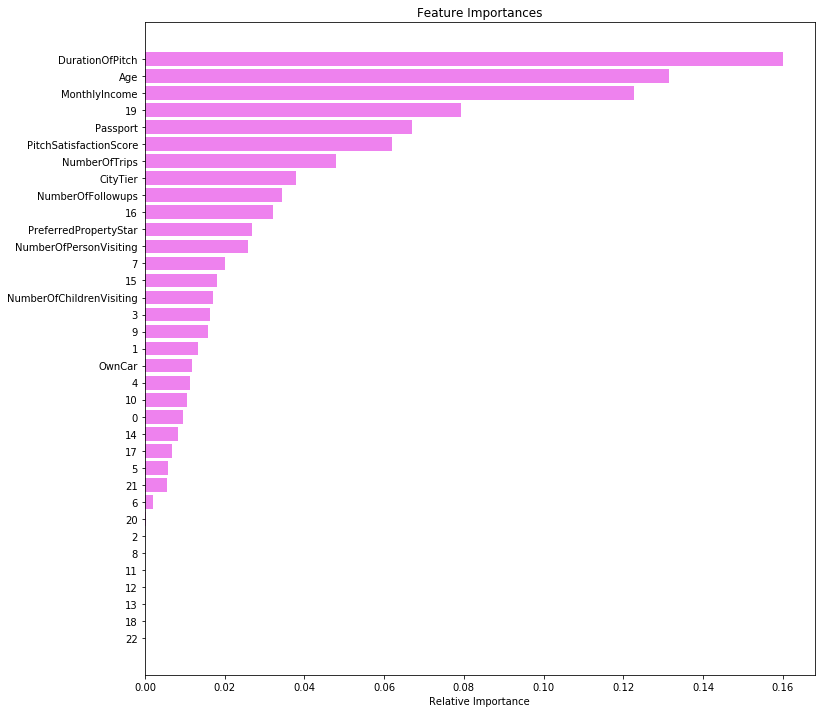

In [195]:
column_names = list(X.columns)
feature_names = column_names

importances = dTree.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#Numbers ARE Categorical Data 

In [196]:
#RANDOM FORREST
#Fitting the model
rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)
rfPreds = rf_estimator.predict(X_val)
#Calculating different metrics
#get_metrics_score(rf_estimator)

accuracy_rfr = accuracy_score(y_val, rfPreds)
# Accuracy seems to be 1 - Mean Absolute Error
print("Accuracy:"+str(accuracy_rfr))

#Creating confusion matrix
#make_confusion_matrix(rf_estimator,y_test)

Accuracy:0.8961748633879781


In [197]:
success_prop = np.round(557/(2370+557),1)
failure_prop = 1-success_prop
print(success_prop)

0.2


In [198]:
# Choose the type of classifier. 
rf_estimator_weighted = RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    "class_weight": [{0: success_prop, 1: failure_prop}],
    "n_estimators": [100,150,200,250],
    "min_samples_leaf": np.arange(5, 10),
    "max_features": np.arange(0.2, 0.7, 0.1),
    "max_samples": np.arange(0.3, 0.7, 0.1),
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_weighted, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_estimator_weighted = grid_obj.best_estimator_

# Fit the best algorithm to the data.
rf_estimator_weighted.fit(X_train, y_train)
rfwPreds = rf_estimator_weighted.predict(X_val)
accuracy_rfr_weighted = accuracy_score(y_val, rfwPreds)
# Accuracy seems to be 1 - Mean Absolute Error
print("Accuracy:"+str(accuracy_rfr_weighted))
#started at 7:23 end 8:02

Accuracy:0.8387978142076503


In [199]:
print("Accuracy Difference:"+str(accuracy_dt - accuracy_rfr))

Accuracy Difference:-0.04508196721311475


In [200]:
#BAGGING CLASSIFIER
bagging_estimator=BaggingClassifier(random_state=1)
bagging_estimator.fit(X_train,y_train)
bcpreds = bagging_estimator.predict(X_val)
accuracy_bc = accuracy_score(y_val, bcpreds)
print("Accuracy:"+str(accuracy_bc))

Accuracy:0.9002732240437158


In [201]:
# Choose the type of classifier. 
bagging_estimator_tuned = BaggingClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {'max_samples': [0.7,0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : [10,20,30,40,50],
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(bagging_estimator_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
bagging_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_estimator_tuned.fit(X_train, y_train)

bcTunedPreds = bagging_estimator_tuned.predict(X_val)
accuracy_bcTuned = accuracy_score(y_val, bcTunedPreds)
print("Accuracy:"+str(accuracy_bcTuned))

Accuracy:0.8989071038251366


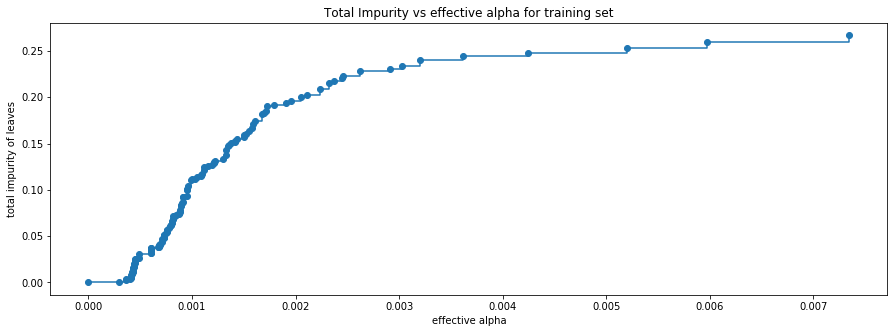

In [202]:
#PRUNING DECISION TREE
clf = DecisionTreeClassifier(random_state=1)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

In [203]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.022733213550432757


In [204]:
clfPred = clf.predict(X_val)
accuracy = accuracy_score(y_val, clfPred)
# There Seems to be no improvement from Pruning
print("Accuracy:"+str(accuracy))

Accuracy:0.819672131147541


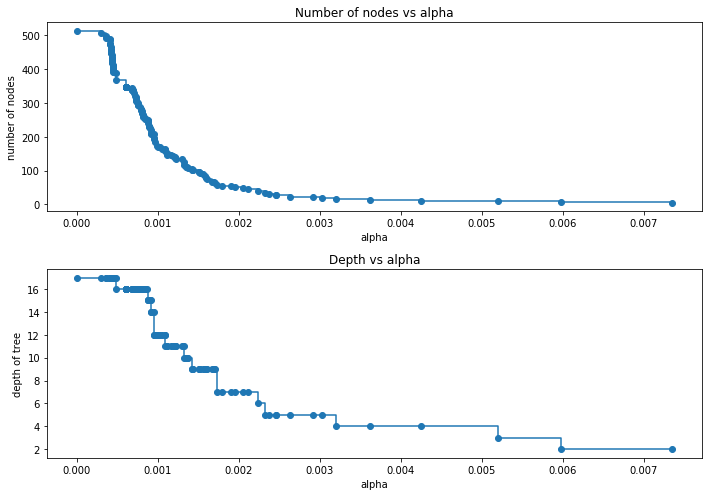

In [205]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1,figsize=(10,7))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [207]:
recall_train=[]
for clf in clfs:
    pred_train3=clf.predict(X_train)
    values_train=metrics.recall_score(y_train,pred_train3)
    recall_train.append(values_train)
recall_test=[]
for clf in clfs:
    pred_test3=clf.predict(X_val)
    values_test=metrics.recall_score(y_val,pred_test3)
    recall_test.append(values_test)

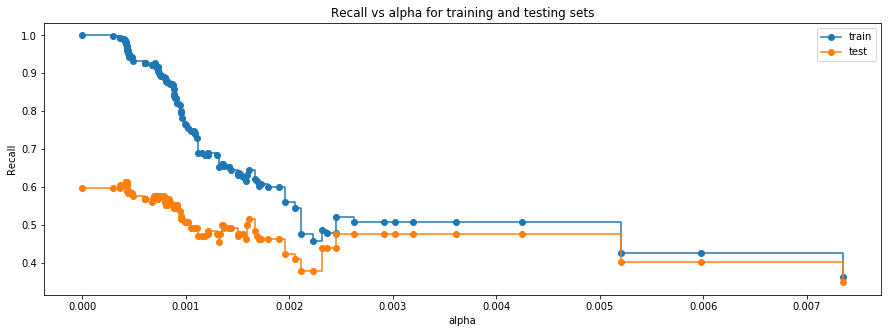

In [208]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xlabel("alpha")
ax.set_ylabel("Recall")
ax.set_title("Recall vs alpha for training and testing sets")
ax.plot(ccp_alphas, recall_train, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, recall_test, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [209]:
# creating the model where we get highest train and test recall
index_best_model = np.argmax(recall_test)
best_model = clfs[index_best_model]
print(best_model)

DecisionTreeClassifier(ccp_alpha=0.0004230393752033844, class_weight=None,
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=1, splitter='best')


In [210]:
clfBMPred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, clfBMPred)
# There still seems to be no improvement from Pruning and themodel isnt much more simple
print("Accuracy:"+str(accuracy))

Accuracy:0.8579234972677595


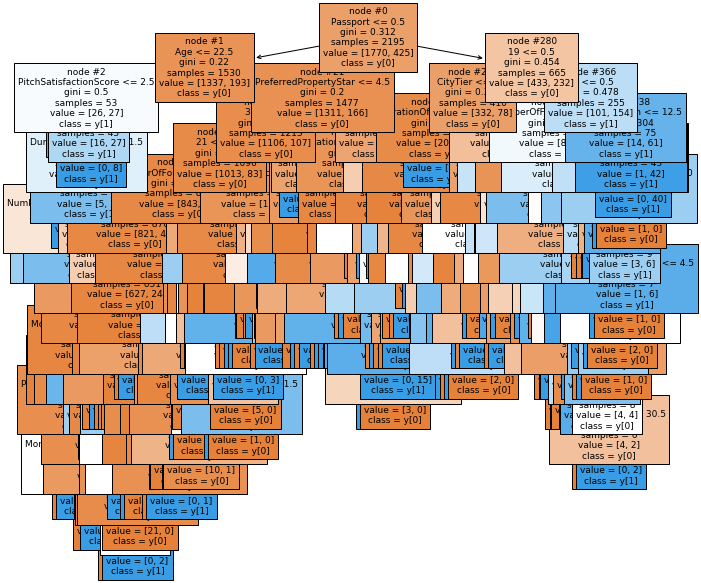

In [211]:
plt.figure(figsize=(10,10))

out = tree.plot_tree(best_model,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
for o in out:
     arrow = o.arrow_patch
     if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(1)
plt.show()
plt.show()

In [ ]:
#THEREFORE PRUNING THE TREE MADE IT APPROXIMATELY AS ACCURATE AS RFR

In [212]:
#ADA BOOST
abc = AdaBoostClassifier(random_state=1)
abc.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=1)

In [213]:
#Using above defined function to get accuracy, recall and precision on train and test set
abc_score=get_metrics_score(abc)

Accuracy on training set :  0.8569476082004556
Accuracy on test set :  0.837431693989071
Recall on training set :  0.41411764705882353
Recall on test set :  0.32575757575757575
Precision on training set :  0.7302904564315352
Precision on test set :  0.589041095890411


In [214]:
#GRADIENT BOOST with ADABOOST

In [215]:
# Choose the type of classifier. 
gbc_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    "n_estimators": [100,150,200,250],
    "subsample":[0.8,0.9,1],
    "max_features":[0.7,0.8,0.9,1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse',
                           init=AdaBoostClassifier(algorithm='SAMME.R',
                                                   base_estimator=None,
                                                   learning_rate=1.0,
                                                   n_estimators=50,
                                                   random_state=1),
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=0.7, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
             

In [216]:
#Using above defined function to get accuracy, recall and precision on train and test set
gbc_tuned_score=get_metrics_score(gbc_tuned)

Accuracy on training set :  0.9384965831435079
Accuracy on test set :  0.8565573770491803
Recall on training set :  0.72
Recall on test set :  0.3939393939393939
Precision on training set :  0.9503105590062112
Precision on test set :  0.6753246753246753


In [ ]:
# XGBOOST 

In [ ]:
# Choose the type of classifier. 

xgb_tuned = XGBClassifier(random_state=1,verbosity=0)

# Grid of parameters to choose from
## add from
parameters = {
    "n_estimators": np.arange(10),#,100,20),
    "scale_pos_weight":[0],#,1,2,5],
    "subsample":[0.5],#,0.7,0.9,1],
    "learning_rate":[0.01],#0.1,0.2,0.05,
    "gamma":[0],#,1,3],
    "colsample_bytree":[0.5],#,0.7,0.9,1],
    "colsample_bylevel":[0.5],#,0.7,0.9,1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

In [ ]:
#Using above defined function to get accuracy, recall and precision on train and test set
xgb_tuned_score=get_metrics_score(xgb_tuned)

In [ ]:
#COMPARING MODELS

In [ ]:
# defining list of models
models = [abc, abc_tuned, gbc, gbc_init, gbc_tuned, xgb, xgb_tuned]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

# looping through all the models to get the accuracy, precall and precision scores
for model in models:
    j = get_metrics_score(model,False)
    acc_train.append(np.round(j[0],2))
    acc_test.append(np.round(j[1],2))
    recall_train.append(np.round(j[2],2))
    recall_test.append(np.round(j[3],2))
    precision_train.append(np.round(j[4],2))
    precision_test.append(np.round(j[5],2))

In [ ]:
comparison_frame = pd.DataFrame({'Model':['AdaBoost with default paramters','AdaBoost Tuned', 
                                          'Gradient Boosting with default parameters','Gradient Boosting with init=AdaBoost',
                                          'Gradient Boosting Tuned','XGBoost with default parameters','XGBoost Tuned'], 
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test}) 
comparison_frame